# Rate of Change

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import seaborn as sns
import os, warnings
from scipy.signal import savgol_filter
%matplotlib inline
warnings.filterwarnings('ignore')
cutOffYear = '1850'

In [2]:
#import country temp data
ctrTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv')

In [3]:
countryTempFull = ctrTemp.dropna()
#List of continents
continents = ['North America','South America','Europe','Asia','Africa','Antarcita']
#Remove continents from country temp
countryTempFull = ctrTemp[~ctrTemp['Country'].isin(continents)]
countryTempFull = countryTempFull[~countryTempFull['Country'].str.contains('(Europe)')]
countryTempFull = countryTempFull.dropna()

In [4]:
#convert date column to datetime and add year column
countryTempFull['dt'] = pd.to_datetime(countryTempFull['dt'])
countryTempFull['Year'] = countryTempFull['dt'].apply(lambda x : x.strftime('%Y'))

In [5]:
#trimming for quality data
countryTemp = countryTempFull[countryTempFull['Year'] >= cutOffYear]

In [6]:
countryTempAvg = countryTemp.groupby(['Country','Year']).mean().reset_index(drop=False)
# countryTempAvg.head()

In [7]:
#find greatest changes in temperature over a 3 year span
data = DataFrame()
for each in countryTempAvg['Country'].unique():
    holder = countryTempAvg[countryTempAvg['Country'] == each]
    holderAvg = holder['AverageTemperature'].mean()
    trimHolder = holder[['Year']+['AverageTemperature']]
    trimHolder = trimHolder.set_index('Year',drop=True)
    diffChange = trimHolder.diff(3)
    diffChange = diffChange.dropna().reset_index(drop=False)
    diffChange['Country'] = each
    diffChange.rename(columns={'AverageTemperature':'TempChange'},inplace=True)
    data = data.append(diffChange)
    
data = data.sort_values('TempChange')
data['AbsTempChange'] = data['TempChange'].apply(lambda x : abs(x))
data = data.sort_values('AbsTempChange', ascending=False).reset_index(drop=True)
# data.head(10)

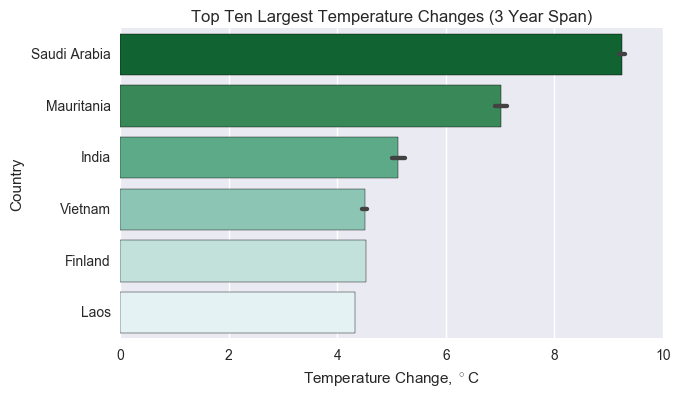

In [8]:
#plot temeprature changes
plt.figure(figsize=(7,4))
ax = sns.barplot(data['AbsTempChange'][0:10],data['Country'][0:10],palette='BuGn_r')
ax.set_xlabel('Temperature Change, $^\circ$C')
ax.set_title('Top Ten Largest Temperature Changes (3 Year Span)')
plt.savefig("./ana_3/topTenDiff.png", bbox_inches='tight',dpi=600)

In [9]:
#easy way to plot data
def plot(zoo):
    holder = countryTempAvg[countryTempAvg['Country'] == zoo]
    plt.plot(holder['Year'],holder['AverageTemperature'])

In [11]:
#take in a list of countries and produce the data to graph it's average temperature +/- uncertainty
def plotData(zoo):
    data = DataFrame()
    avgHolder = countryTempFull.groupby(['Country','Year']).mean().reset_index(drop=False)
    for each in zoo:
        holderTemp = avgHolder[avgHolder['Country'] == each]
        holderTemp['AverageTemperature'] = savgol_filter(holderTemp['AverageTemperature'], 3, 1)

        holderTemp['Upper'] = holderTemp['AverageTemperature'] + holderTemp['AverageTemperatureUncertainty']
        holderTemp['Lower'] = holderTemp['AverageTemperature'] - holderTemp['AverageTemperatureUncertainty']

        holderT = holderTemp[['Country']+['Year']+['AverageTemperature']]
        holderT.columns = ['Country','Year','AvgTemp']
        holderT['Count'] = 0
        holderU = holderTemp[['Country']+['Year']+['Upper']]
        holderU.columns = ['Country','Year','AvgTemp']
        holderU['Count'] = 1
        holderL = holderTemp[['Country']+['Year']+['Lower']]
        holderL.columns = ['Country','Year','AvgTemp']
        holderL['Count'] = 2

        name = each.replace(" ","")
        name = 'all'+name

        name = holderT.append(holderU)
        name = name.append(holderL).sort_values('Year').reset_index(drop=True)

        data = data.append(name)
    return data

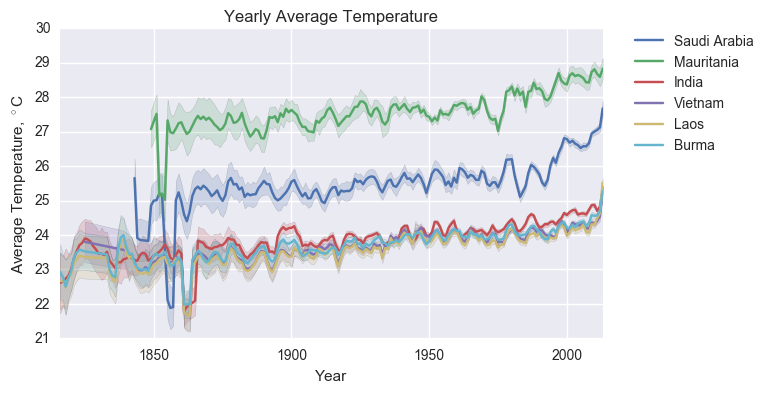

In [13]:
#plot the six countries mentioned above
plt.figure(figsize=(7,4))
countries = ['Saudi Arabia','Mauritania','India','Vietnam','Laos','Burma']
# stuff = plotData(data['Country'].unique()[:6])
stuff = plotData(countries)
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=stuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("./ana_3/maxDiffs.png", bbox_inches='tight',dpi=600)

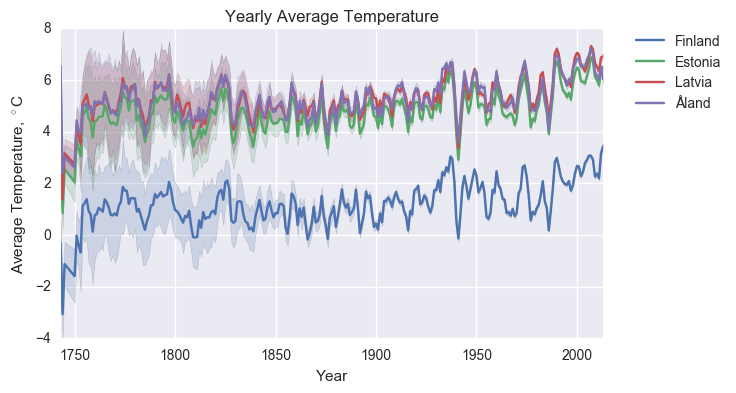

In [14]:
#plot the other four in the top ten
plt.figure(figsize=(7,4))
countries2 = ['Finland','Estonia','Latvia','Åland']
# moreStuff = plotData(data['Country'].unique()[6:11])
moreStuff = plotData(countries2)
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=moreStuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
# ax.set_ylim([-10,10])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("./ana_3/maxDiffs2.png", bbox_inches='tight',dpi=600)